In [1]:
import giggle_functions as giggle
import numpy as np 
import matplotlib.pyplot as plt


import math
import matplotlib.image as mpimg
from scipy.interpolate import griddata
from scipy import special
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import simps
from astropy import constants as const
from scipy.interpolate import griddata
from scipy import ndimage as ndimage
import disk_ecc_spiral as disk
import disk_ecc as kevindisk

from astropy import units as u
from astropy.constants import G, sigma_sb, k_B, m_p

from scipy.interpolate import LinearNDInterpolator as interpnd

1d z-array [1.49597871e+12 3.53094094e+12 5.56590316e+12 ... 2.53909388e+15
 2.54112884e+15 2.54316380e+15]
rf (1d) [[1.49597871e+14 1.49597871e+14 1.49597871e+14 ... 1.49597871e+14
  1.49597871e+14 1.49597871e+14]
 [1.79277609e+14 1.79277609e+14 1.79277609e+14 ... 1.79277609e+14
  1.79277609e+14 1.79277609e+14]
 [2.08957346e+14 2.08957346e+14 2.08957346e+14 ... 2.08957346e+14
  2.08957346e+14 2.08957346e+14]
 ...
 [1.49004276e+16 1.49004276e+16 1.49004276e+16 ... 1.49004276e+16
  1.49004276e+16 1.49004276e+16]
 [1.49301073e+16 1.49301073e+16 1.49301073e+16 ... 1.49301073e+16
  1.49301073e+16 1.49301073e+16]
 [1.49597871e+16 1.49597871e+16 1.49597871e+16 ... 1.49597871e+16
  1.49597871e+16 1.49597871e+16]]


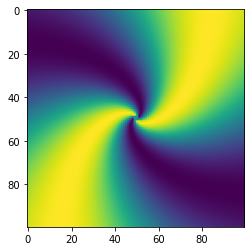

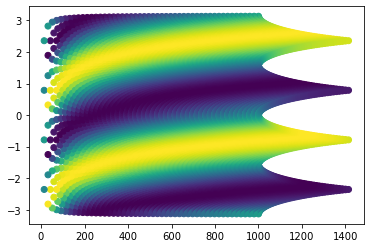

g_r [[1414.21356237 1400.00145758 1385.9380959  ... 1385.9380959
  1400.00145758 1414.21356237]
 [1400.00145758 1385.64359142 1371.43300489 ... 1371.43300489
  1385.64359142 1400.00145758]
 [1385.9380959  1371.43300489 1357.07362046 ... 1357.07362046
  1371.43300489 1385.9380959 ]
 ...
 [1385.9380959  1371.43300489 1357.07362046 ... 1357.07362046
  1371.43300489 1385.9380959 ]
 [1400.00145758 1385.64359142 1371.43300489 ... 1371.43300489
  1385.64359142 1400.00145758]
 [1414.21356237 1400.00145758 1385.9380959  ... 1385.9380959
  1400.00145758 1414.21356237]]
g_phi [[-2.35619449 -2.36639822 -2.37681013 ...  2.37681013  2.36639822
   2.35619449]
 [-2.34599076 -2.35619449 -2.36661078 ...  2.36661078  2.35619449
   2.34599076]
 [-2.33557885 -2.3457782  -2.35619449 ...  2.35619449  2.3457782
   2.33557885]
 ...
 [-0.8060138  -0.79581445 -0.78539816 ...  0.78539816  0.79581445
   0.8060138 ]
 [-0.79560189 -0.78539816 -0.77498187 ...  0.77498187  0.78539816
   0.79560189]
 [-0.78539816 -0.77

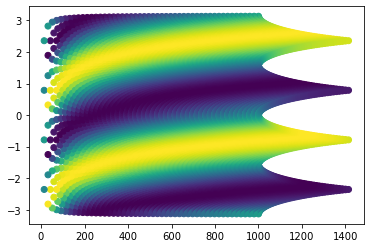

acf [:,:,0] [[1.49597871e+14 1.49597871e+14 1.49597871e+14 ... 1.49597871e+14
  1.49597871e+14 1.49597871e+14]
 [1.79277609e+14 1.79277609e+14 1.79277609e+14 ... 1.79277609e+14
  1.79277609e+14 1.79277609e+14]
 [2.08957346e+14 2.08957346e+14 2.08957346e+14 ... 2.08957346e+14
  2.08957346e+14 2.08957346e+14]
 ...
 [1.49004276e+16 1.49004276e+16 1.49004276e+16 ... 1.49004276e+16
  1.49004276e+16 1.49004276e+16]
 [1.49301073e+16 1.49301073e+16 1.49301073e+16 ... 1.49301073e+16
  1.49301073e+16 1.49301073e+16]
 [1.49597871e+16 1.49597871e+16 1.49597871e+16 ... 1.49597871e+16
  1.49597871e+16 1.49597871e+16]]
pcf[:,:,0]-np.pi [[-3.14159265 -3.09326046 -3.04492826 ...  3.04492826  3.09326046
   3.14159265]
 [-3.14159265 -3.09326046 -3.04492826 ...  3.04492826  3.09326046
   3.14159265]
 [-3.14159265 -3.09326046 -3.04492826 ...  3.04492826  3.09326046
   3.14159265]
 ...
 [-3.14159265 -3.09326046 -3.04492826 ...  3.04492826  3.09326046
   3.14159265]
 [-3.14159265 -3.09326046 -3.04492826 ... 

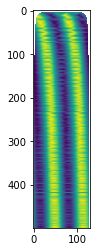

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [2]:
'''testing disk model'''


x = disk.Disk()

In [7]:
'''I think... this should give surface density for every point in the disk in a 2d grid
after being perturbed.'''

def perturbed_sigma(grid_radius, grid_angle, p, rin, rout ,md, beta, m, alpha, pos):
    
    '''Spiral-perturbed surface density [msun / au^2]
    grid_radius = radial grid [au]
    grid_angle = azimuthal grid [-np.pi,np.pi] [rad]
    p = power law index of the density profile. \Sigma \propto r^(p)
    rin = inner radius of the disc [au]
    rout = outer radius of the disc [au]
    md = mass of the disc [msun]
    m = number of the spiral arms
    alpha = pitch angle of the spiral [rad]
    pos = angle of the spiral within the disc [rad]'''
    
    
    return   beta**(-1/2) * -np.cos(-(m * 
    grid_angle + m/np.tan(alpha) * -np.log(grid_radius) + pos))

In [8]:
#understanding structure of perturbed_sigma and how to use it
#Parameters
ms = 1 #star mass
md = 0.35 #disc mass
p = -.5 #surface density
ap = 60*np.pi/180 #pitch angle
m = 2 #azimuthal wavenumber
beta = 5 #cool
incl = np.pi/2.1 #inclination of the disc towards the line of sight
pos = 90 # rotation of spiral (degrees), starting north, cw

#1d r array
r = np.linspace(1,100,50)
#1d phi array
phi = np.linspace(-np.pi,np.pi,180)
#meshgrid but... why not use r array? And what is purpose of j? Indexing?
gr, gphi = np.mgrid[1:100:50j, -np.pi:np.pi:180j] #rin:rout:resolution
#print("gr shape " + str(gr.shape))
#print("gphi shape " + str(gphi.shape))
#print("gr" + str(gr))
#print("gphi" + str(gphi))
gx, gy = np.mgrid[-100:100:200j,-100:100:200j]
car = np.linspace(-100,100,200)
grid_angle = 0*gx
g_r = (gx**2+gy**2)**(0.5)
#print(str(gr.shape)+"gr shape")

for i in range(len(car)):
    for j in range(len(car)):
        grid_angle[i,j] = math.atan2(car[i], car[j])

#print(str(grid_angle.shape)+"grid_angle shape")
#print("grid_angle" + str(grid_angle[200,:]))
#print("g_r " + str(g_r[200,:]))
#print(str(gr.shape)+"gr shape")
spir0 = perturbed_sigma(g_r, grid_angle, p, 1, 100, md, beta, m, ap,0)
#print(spir0.shape)
spir1 = perturbed_sigma(g_r, grid_angle, p, 1, 100, md, beta, m, ap,30)
spir2 = perturbed_sigma(g_r, grid_angle, p, 1, 100, md, beta, m, ap,90)



In [9]:
gr, gphi = np.mgrid[1:100:50j, -np.pi:np.pi:180j]

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [10]:
x_grid_test, y_grid_test = pol2cart(gr, gphi)
#plt.scatter(x_grid_test, y_grid_test)
#plt.show()

#x_coord, y_coord = np.meshgrid(x_grid_test, y_grid_test)

#plt.imshow(x_coord)
#plt.colorbar()


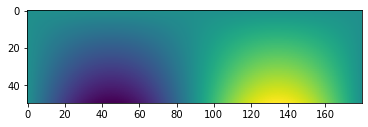

In [11]:
plt.imshow(y_grid_test)

In [12]:
#x_coord, y_coord = np.meshgrid(x_grid_test, y_grid_test)

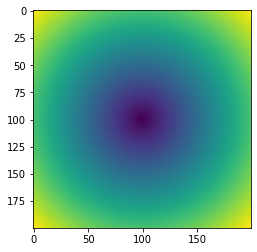

In [13]:
plt.imshow(g_r)

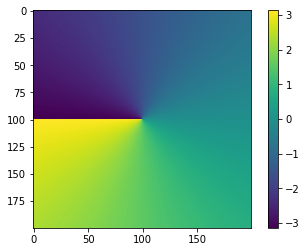

In [14]:
plt.imshow(grid_angle)
plt.colorbar()

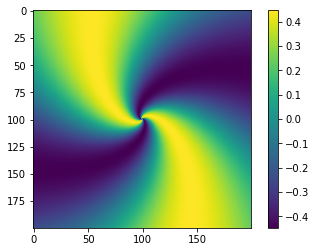

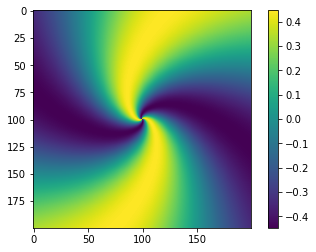

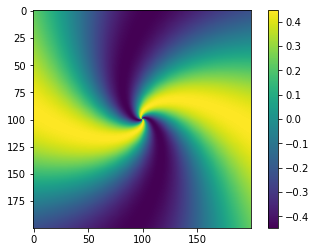

In [15]:
#ok... but this is a square and not a disk.... and also what are the units here?? I'm guessing this has to be compared
#with some already existing global surface density...

plt.imshow(spir0)
plt.colorbar()
plt.show()
plt.imshow(spir1)
plt.colorbar()
plt.show()
plt.imshow(spir2)
plt.colorbar()
plt.show()

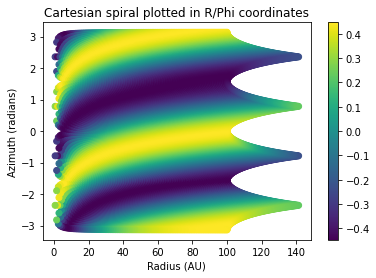

In [16]:
fig, ax = plt.subplots()
plt.scatter(g_r, grid_angle, c=spir2)
ax.set_xlabel("Radius (AU)")
ax.set_ylabel("Azimuth (radians)")
ax.set_title("Cartesian spiral plotted in R/Phi coordinates")
plt.colorbar()

In [17]:
for i in range(len(car)):
    for j in range(len(car)):
        if(g_r[i,j] > 100):
            spir2[i,j] = -np.inf

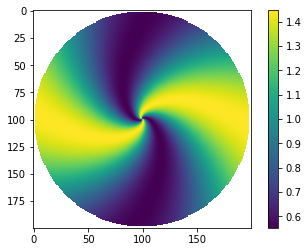

In [18]:
plt.imshow(spir2+1)
plt.colorbar()

In [19]:
radius = np.linspace(1, 50, 200)
phi = np.linspace(-np.pi, np.pi, 200)

In [20]:
rr, pp = np.meshgrid(radius, phi)

In [21]:
interp_test = interpnd((np.ravel(g_r), np.ravel(grid_angle)), np.ravel(spir2))

In [22]:
z = interp_test(rr, pp)

In [23]:
z.shape

(200, 200)

In [24]:
#plt.imshow(z)

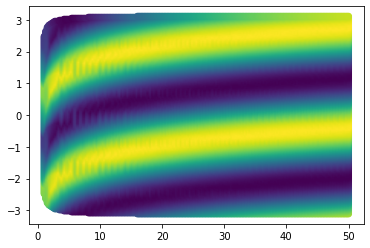

In [25]:
plt.scatter(rr, pp, c=z)

In [26]:
unpert_sigma = giggle.sigma(p, 1, 100, md, g_r)

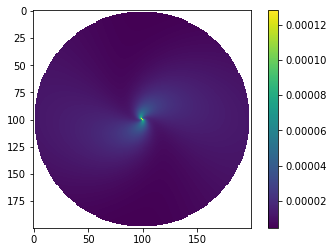

In [27]:
spiral_sigma = spir2*unpert_sigma + unpert_sigma

for i in range(len(car)):
    for j in range(len(car)):
        if(g_r[i,j] > 100):
            spiral_sigma[i,j] = -np.inf

plt.imshow(spiral_sigma)
plt.colorbar()

In [28]:
 def set_structure(self):
        #tst=time.clock()
        '''Calculate the disk density and temperature structure given the specified parameters'''
        # Define the desired regular cylindrical (r,z) grid
        nac = 500#256             # - number of unique a rings
        #nrc = 256             # - numver of unique r points
        amin = self.Ain       # - minimum a [AU]
        amax = self.Aout      # - maximum a [AU]
        e = self.ecc          # - eccentricity
        nzc = int(2.5*nac)#nac*5           # - number of unique z points
        '''defining z-array: .1 AU to specified max value in AU. logarithmic. number specified by
        # of annuli'''
        zmin = .1*Disk.AU      # - minimum z [AU]
        nfc = self.nphi       # - number of unique f points
        af = np.logspace(np.log10(amin),np.log10(amax),nac)
        zf = np.logspace(np.log10(zmin),np.log10(self.zmax),nzc)

        #adding this to triple check z-dimension is doing what I think it is
        print("1d z-array " + str(zf))

        pf = np.linspace(0,2*np.pi,self.nphi) #f is with refrence to semi major axis
        ff = (pf - self.aop) % (2*np.pi) # phi values are offset by aop- refrence to sky
        rf = np.zeros((nac,nfc))
        for i in range(nac):
            for j in range(nfc):
                rf[i,j] = (af[i]*(1.-e*e))/(1.+e*np.cos(ff[j]))

        '''1d array of z-values as ones'''
        idz = np.ones(nzc)
        idf = np.ones(self.nphi)
        #rcf = np.outer(rf,idz)
        ida = np.ones(nac)
        ##zcf = np.outer(ida,zf)
        ##acf = af[:,np.newaxis]*np.ones(nzc)
        #order of dimensions: a, f, z
        '''meshgrid of z values above midplane'''
        pcf,acf,zcf = np.meshgrid(pf,af,zf)
        #zcf = (np.outer(ida,idf))[:,:,np.newaxis]*zf
        #pcf = (np.outer(ida,pf))[:,:,np.newaxis]*idz
        fcf = (pcf - self.aop) % (2*np.pi)
        #acf = (np.outer(af,idf))[:,:,np.newaxis]*idz
        
        '''should be 0 grid in shape of radius, phi, z above midplane'''
        rcf=rf[:,:,np.newaxis]*idz
        print(str(rcf.shape))
        #print("coords init {t}".format(t=time.clock()-tst))


        # Here introduce new z-grid (for now just leave old one in)

        # Interpolate dust temperature and density onto cylindrical grid
        ###### doesnt seem to be used anywhere ######


        # bundle the grid for helper functions
        ###### add angle to grid? ######
        '''nac, nfc, nzc are resolution (int) in each dimension. rcf is 0s grid in 3d. 
        amax is max a (AU), zcf is z meshgrid'''
        grid = {'nac':nac,'nfc':nfc,'nzc':nzc,'rcf':rcf,'amax':amax,'zcf':zcf}#'ff':ff,'af':af,
        self.grid=grid

        #print("grid {t}".format(t=time.clock()-tst))
        #define temperature structure
        # use Dartois (03) type II temperature structure
        ###### expanding to 3D should not affect this ######
        delta = 1.                # shape parameter
        rcf150=rcf/(150.*Disk.AU)
        rcf150q=rcf150**self.qq
        
        '''# zq0 = Zq, in AU, at 150 AU (????)'''
        '''zq should be 3d and scaled by 150 AU...???'''
        zq = self.zq0*Disk.AU*rcf150**1.3
        print("shape of zq " +str(zq.shape))
        print("zq " +str(zq))
    
        #zq = self.zq0*Disk.AU*(rcf/(150*Disk.AU))**1.1
        tmid = self.tmid0*rcf150q
        tatm = self.tatm0*rcf150q
        tempg = tatm + (tmid-tatm)*np.cos((np.pi/(2*zq))*zcf)**(2.*delta)

        '''ii is 3d boolean grid of z values above some critical value'''
        ii = zcf > zq
        tempg[ii] = tatm[ii]
        #Type I structure
#        tempg = tmid*np.exp(np.log(tatm/tmid)*zcf/zq)
        ###### this step is slow!!! ######

        # Calculate vertical density structure

        ## Circular:
        #Sc = self.McoG*(2.-self.pp)/(2*np.pi*self.Rc*self.Rc)
        #siggas = Sc*(rf/self.Rc)**(-1*self.pp)*np.exp(-1*(rf/self.Rc)**(2-self.pp))
        ## Elliptical:
        #asum = (np.power(af,-1*self.pp)).sum()
        rp1 = np.roll(rf,-1,axis=0)
        rm1 = np.roll(rf,1,axis=0)
        #*** Approximations used here ***#

        Sc = self.McoG*(2.-self.pp)/(self.Rc*self.Rc)
        siggas_r = Sc*(acf[:,:,0]/self.Rc)**(-1*self.pp)*np.exp(-1*(acf[:,:,0]/self.Rc)**(2-self.pp))

        dsdth = (acf[:,:,0]*(1-e*e)*np.sqrt(1+2*e*np.cos(fcf[:,:,0])+e*e))/(1+e*np.cos(fcf[:,:,0]))**2
        siggas = ((siggas_r*np.sqrt(1.-e*e))/(2*np.pi*acf[:,:,0]*np.sqrt(1+2*e*np.cos(fcf[:,:,0])+e*e)))*dsdth

        ## Add an extra ring
        if self.ring is not None:
            w = np.abs(rcf-self.Rring)<self.Wring/2.
            if w.sum()>0:
                tempg[w] = tempg[w]*(rcdf[w]/(150*Disk.AU))**(self.sig_enhance-self.qq)/((rcf[w].max())/(150.*Disk.AU))**(-self.qq+self.sig_enhance)


        self.calc_hydrostatic(tempg,siggas,grid)

        self.vel = np.sqrt(Disk.G*self.Mstar/(acf*(1-self.ecc**2.)))*(np.cos(self.aop+fcf)+self.ecc*self.cosaop)


        # Check for NANs
        ### nolonger use Omg ###
        #ii = np.isnan(Omg)
        #Omg[ii] = Omk[ii]
        ii = np.isnan(self.rho0)
        if ii.sum() > 0:
            self.rho0[ii] = 1e-60
            print('Beware: removed NaNs from density (#%s)' % ii.sum())
        ii = np.isnan(tempg)
        if ii.sum() > 0:
            tempg[ii] = 2.73
            print('Beware: removed NaNs from temperature (#%s)' % ii.sum())

        #print("nan chekc {t}".format(t=time.clock()-tst))
        # find photodissociation boundary layer from top
        zpht_up = np.zeros((nac,nfc))
        zpht_low = np.zeros((nac,nfc))
        sig_col = np.zeros((nac,nfc,nzc))
        #zice = np.zeros((nac,nfc))
        for ia in range(nac):
            for jf in range (nfc):
                psl = (Disk.Hnuctog/Disk.m0*self.rho0[ia,jf,:])[::-1]
                zsl = self.zmax - (zcf[ia,jf,:])[::-1]
                foo = (zsl-np.roll(zsl,1))*(psl+np.roll(psl,1))/2.
                foo[0] = 0
                nsl = foo.cumsum()
                sig_col[ia,jf,:] = nsl[::-1]*Disk.m0/Disk.Hnuctog
                pht = (np.abs(nsl) >= self.sigbound[0])
                if pht.sum() == 0:
                    zpht_up[ia,jf] = np.min(self.zmax-zsl)
                else:
                    zpht_up[ia,jf] = np.max(self.zmax-zsl[pht])
                #Height of lower column density boundary
                pht = (np.abs(nsl) >= self.sigbound[1])
                if pht.sum() == 0:
                    zpht_low[ia,jf] = np.min(self.zmax-zsl)
                else:
                    zpht_low[ia,jf] = np.max(self.zmax-zsl[pht])
                #used to be a seperate loop
                ###### only used for plotting
                #foo = (tempg[ia,jf,:] < Disk.Tco)
                #if foo.sum() > 0:
                #    zice[ia,jf] = np.max(zcf[ia,jf,foo])
                #else:
                #    zice[ia,jf] = zmin
        self.sig_col = sig_col
        #szpht = zpht
        #print("Zpht {t} seconds".format(t=(time.clock()-tst)))
        self.af = af
        #self.ff = ff
        #self.rf = rf
        self.pf = pf
        self.nac = nac
        self.zf = zf
        self.nzc = nzc
        self.tempg = tempg
        #self.Omg0 = Omg#velrot
        self.zpht_up = zpht_up
        self.zpht_low = zpht_low
        self.pcf = pcf  #only used for plotting can remove after testing
        self.rcf = rcf  #only used for plotting can remove after testing


In [29]:

#x=disk.Disk()

In [30]:
#%run raytrace.py
#total_model(x)

In [31]:
#y=kevindisk.Disk()

In [32]:
#%run raytrace.py
#total_model(y)

In [33]:

nac = 500#256             # - number of unique a rings
#nrc = 256             # - numver of unique r points
amin = 1       # - minimum a [AU]
amax = 100      # - maximum a [AU]
e = 0          # - eccentricity
nzc = int(2.5*nac)#nac*5           # - number of unique z points
'''defining z-array: .1 AU to specified max value in AU. logarithmic. number specified by
# of annuli'''
zmin = .1      # - minimum z [AU]
nfc = 180      # - number of unique f points
af = np.logspace(np.log10(amin),np.log10(amax),nac)
zf = np.logspace(np.log10(zmin),np.log10(10),nzc)

#adding this to triple check z-dimension is doing what I think it is
#print("1d z-array " + str(zf))

pf = np.linspace(0,2*np.pi,180) #f is with refrence to semi major axis
ff = (pf - 0) % (2*np.pi) # phi values are offset by aop- refrence to sky
rf = np.zeros((nac,nfc))
for i in range(nac):
    for j in range(nfc):
        rf[i,j] = (af[i]*(1.-e*e))/(1.+e*np.cos(ff[j]))

'''1d array of z-values as ones'''
idz = np.ones(nzc)
idf = np.ones(180)
#rcf = np.outer(rf,idz)
ida = np.ones(nac)
##zcf = np.outer(ida,zf)
##acf = af[:,np.newaxis]*np.ones(nzc)
#order of dimensions: a, f, z
'''meshgrid of z values above midplane'''
pcf,acf,zcf = np.meshgrid(pf,af,zf)
#zcf = (np.outer(ida,idf))[:,:,np.newaxis]*zf
#pcf = (np.outer(ida,pf))[:,:,np.newaxis]*idz
fcf = (pcf - 0) % (2*np.pi)
#acf = (np.outer(af,idf))[:,:,np.newaxis]*idz

'''should be 0 grid in shape of radius, phi, z above midplane'''
rcf=rf[:,:,np.newaxis]*idz

In [34]:

#r = np.linspace(1, 10, 50)
#p = np.linspace(0, np.pi*2, 180)
r_grid, phi_grid = np.meshgrid(r,p)

In [35]:
ap = 30*np.pi/180 #pitch angle

#understanding structure of perturbed_sigma and how to use it
#Parameters
ms = 1 #star mass
md = 0.35 #disc mass
p = -.5 #surface density
ap = 30*np.pi/180 #pitch angle
m = 2 #azimuthal wavenumber
beta = 5 #cool
incl = np.pi/6 #inclination of the disc towards the line of sight
pos = 90 # rotation of spiral (degrees), starting north, cw

gx, gy = np.mgrid[-100:100:100j,-100:100:100j]
grid_radius = np.sqrt(gx**2 + gy**2)

uphC_test = giggle.uphC(gx, gy, ms, md, p, m, 1, beta, 10, 100, ap, 0)


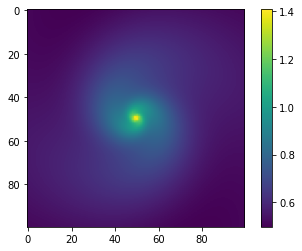

In [36]:
plt.imshow(np.log10(uphC_test))
plt.colorbar()

In [37]:
urC_test = giggle.urC(gx, gy, ms, md, p, m, 1, beta, 10, 100, ap, 0)

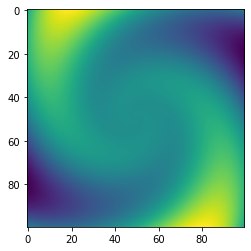

In [38]:
plt.imshow(urC_test)

In [39]:
gr_vel, gphi_vel = cart2pol(gx, gy)

In [40]:
urC_test.shape

(100, 100)

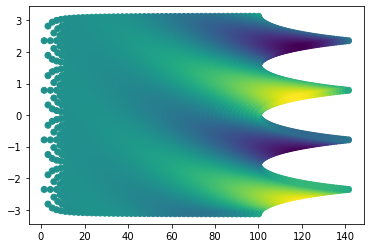

In [41]:
plt.scatter(gr_vel, gphi_vel, c=urC_test)

In [42]:
interp_test_rad = interpnd((np.ravel(gr_vel), np.ravel(gphi_vel)), np.ravel(urC_test))

In [43]:
vel_r = interp_test_rad(rr, pp)

In [44]:
vel_r.shape

(200, 200)

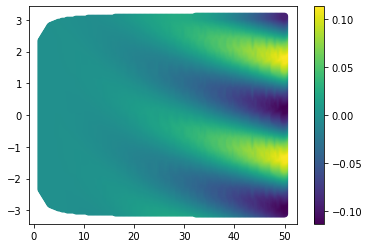

In [45]:
plt.scatter(rr, pp, c=vel_r)
plt.colorbar()

In [46]:
nanmask = np.isnan(vel_r)
vel_r[nanmask] = 0

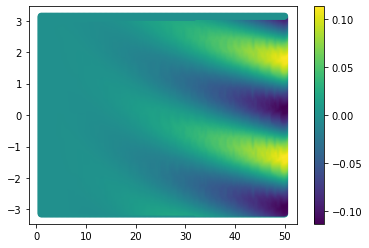

In [47]:
plt.scatter(rr, pp,c=vel_r)
plt.colorbar()

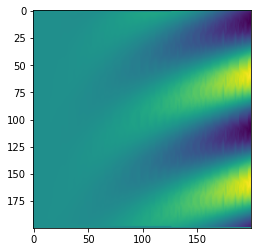

In [48]:
plt.imshow(vel_r)

In [49]:
interp_test_phi = interpnd((np.ravel(gr_vel), np.ravel(gphi_vel)), np.ravel(uphC_test))

In [50]:
vel_phi = interp_test_phi(rr, pp)

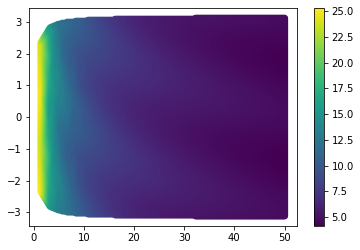

In [51]:
plt.scatter(rr, pp, c=vel_phi)
plt.colorbar()

In [52]:
def keplerian(ms, r):
    v = np.sqrt(G*(ms * u.M_sun.to(u.kg) /(r*u.AU.to(u.meter))))
    return v

In [53]:
kep_test = keplerian(1, np.linspace(1, 10, 10))

In [54]:
kep_test

<Quantity [29784.69182968, 21060.95756832, 17196.19984559, 14892.34591484,
           13320.11912401, 12159.54952146, 11257.55535115, 10530.47878416,
            9928.23060989,  9418.7465588 ] m(3/2) / (kg(1/2) s)>

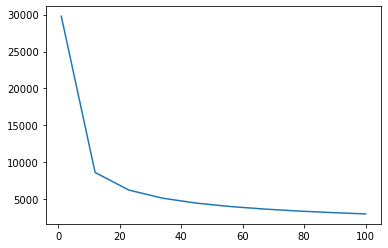

In [55]:
plt.plot(np.linspace(1, 100, 10), keplerian(1, np.linspace(1, 100, 10)))

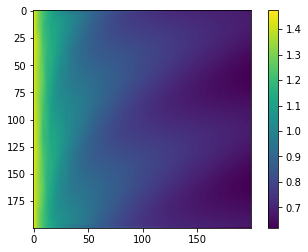

In [56]:
phi_nan_mask = np.isnan(vel_phi)
#rr[phi_nan_mask]
phi_nan_kep = keplerian(ms, rr[phi_nan_mask])/1000
vel_phi[phi_nan_mask] = phi_nan_kep

plt.imshow(np.log10(vel_phi))
plt.colorbar()

In [57]:
gx, gy = np.mgrid[-100:100:400j,-100:100:400j]
g_r, g_phi = cart2pol(gx, gy)
car = np.linspace(-100,100,400)
grid_angle = 0*gx
#g_r = (gx**2+gy**2)**(0.5)
#print(str(gr.shape)+"gr shape")

#print(str(grid_angle.shape)+"grid_angle shape")
#print(str(gr.shape)+"gr shape")
spir0 = giggle.perturbed_sigma(g_r, g_phi, p, 1, 100, md, beta, m, ap,0)

#plt.imshow(spir0)
#plt.savefig("cart_spir_surf.png")
#plt.show()


#plt.scatter(g_r, g_phi, c=spir0)
#plt.savefig("spiral_b4_interp_surf.png")
#plt.show()



interp_test = interpnd((np.ravel(g_r), np.ravel(g_phi)), np.ravel(spir0))
siggas = interp_test(acf[:,:,0], pcf[:,:,0]-np.pi)

In [58]:
siggas

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.44378046, 0.44645864, ..., 0.42397763, 0.43252378,
               nan],
       [       nan, 0.44230061, 0.44501505, ..., 0.41863153, 0.4289849 ,
               nan],
       [       nan, 0.43914888, 0.44355217, ..., 0.41333056, 0.42403142,
               nan]])

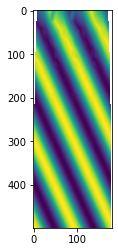

In [59]:
plt.imshow(siggas)

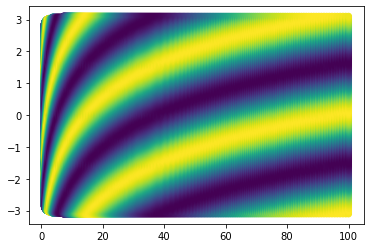

In [61]:
plt.scatter(acf[:,:,0], pcf[:,:,0]-np.pi, c=siggas)

In [62]:
x, y = pol2cart(acf[:,:,0], pcf[:,:,0])

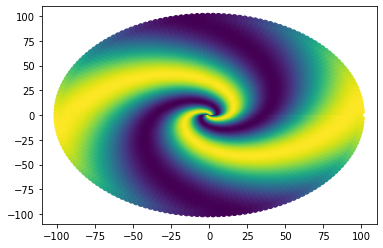

In [63]:
plt.scatter(x, y, c=siggas)